# домашнее задание 4 - кластеризация

**задачи:**
1. преобразовать датасет (процессинг категориальных признаков, копия данных в df_not_processed, scale датасета)
2. сделать k-means кластеризацию (записать cluster в df_not_processed, вывести статистику, графики. попробовать объяснить принцип кластеризации), оценить метриками, вывести результат
3. подобрать оптимальное число кластеров с помощью "метод локтя", вывести статистику, графики, метрики, объяснить результат
4. сделать dbscan кластеризацию, подобрать оптимальные параметры, посчитать метрики, вывести статистику, объяснить результат
5. ответить на вопрос - какой из методов кластеризации больше подходит для вашего датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./StudentPerformanceFactors.csv')

print(df.shape)
print(df.head())
print(df.info())
print(df.isnull().sum())

(6607, 20)
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0    

## 1. преобразование датасета

In [3]:
df['Teacher_Quality'].fillna(df['Teacher_Quality'].mode()[0], inplace=True)
df['Parental_Education_Level'].fillna(df['Parental_Education_Level'].mode()[0], inplace=True)
df['Distance_from_Home'].fillna(df['Distance_from_Home'].mode()[0], inplace=True)

print("пропуски после обработки:")
print(df.isnull().sum().sum())

пропуски после обработки:
0


In [4]:
categorical_columns = ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
                      'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
                      'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level',
                      'Distance_from_Home', 'Gender']

for col in categorical_columns:
    df[col] = df[col].astype('category')

print("категориальные признаки помечены как 'category'")
print(f"количество категориальных признаков: {len(categorical_columns)}")

категориальные признаки помечены как 'category'
количество категориальных признаков: 13


In [5]:
category_columns_list = df.select_dtypes(include=['category']).columns.tolist()

print(f"найдено категориальных колонок: {len(category_columns_list)}")
print("список категориальных колонок:")
for col in category_columns_list:
    print(f"  - {col}: {df[col].nunique()} уникальных значений")

df = pd.get_dummies(df, columns=category_columns_list, drop_first=True)

print(f"\nразмер данных после one-hot encoding: {df.shape}")

найдено категориальных колонок: 13
список категориальных колонок:
  - Parental_Involvement: 3 уникальных значений
  - Access_to_Resources: 3 уникальных значений
  - Extracurricular_Activities: 2 уникальных значений
  - Motivation_Level: 3 уникальных значений
  - Internet_Access: 2 уникальных значений
  - Family_Income: 3 уникальных значений
  - Teacher_Quality: 3 уникальных значений
  - School_Type: 2 уникальных значений
  - Peer_Influence: 3 уникальных значений
  - Learning_Disabilities: 2 уникальных значений
  - Parental_Education_Level: 3 уникальных значений
  - Distance_from_Home: 3 уникальных значений
  - Gender: 2 уникальных значений

размер данных после one-hot encoding: (6607, 28)


In [6]:
df_not_processed = df.copy()

print("создана копия данных df_not_processed")
print(f"размер: {df_not_processed.shape}")

создана копия данных df_not_processed
размер: (6607, 28)


In [7]:
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"числовые признаки для нормализации ({len(numeric_features)}):")
for col in numeric_features[:10]:
    print(f"  - {col}")
if len(numeric_features) > 10:
    print(f"  ... и еще {len(numeric_features) - 10} признаков")

scaler = StandardScaler()

df[numeric_features] = scaler.fit_transform(df[numeric_features])

print("\nнормализация применена")
print("статистика после нормализации:")
print(df[numeric_features[:5]].describe())

числовые признаки для нормализации (7):
  - Hours_Studied
  - Attendance
  - Sleep_Hours
  - Previous_Scores
  - Tutoring_Sessions
  - Physical_Activity
  - Exam_Score

нормализация применена
статистика после нормализации:
       Hours_Studied    Attendance   Sleep_Hours  Previous_Scores  \
count   6.607000e+03  6.607000e+03  6.607000e+03     6.607000e+03   
mean   -1.161474e-16 -3.089199e-16 -2.016449e-16     2.048712e-16   
std     1.000076e+00  1.000076e+00  1.000076e+00     1.000076e+00   
min    -3.167760e+00 -1.730158e+00 -2.063380e+00    -1.741167e+00   
25%    -6.636453e-01 -8.641026e-01 -7.009903e-01    -8.383073e-01   
50%     4.118568e-03  1.953115e-03 -1.979558e-02    -4.898448e-03   
75%     6.718825e-01  8.680088e-01  6.613991e-01     8.979612e-01   
max     4.010702e+00  1.734065e+00  2.023788e+00     1.731370e+00   

       Tutoring_Sessions  
count       6.607000e+03  
mean        7.850707e-17  
std         1.000076e+00  
min        -1.213934e+00  
25%        -4.012417

## 2. k-means кластеризация

In [8]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(df)

df_not_processed['cluster_kmeans'] = clusters_kmeans

print(f"k-means кластеризация выполнена с {n_clusters} кластерами")
print(f"распределение по кластерам:")
print(df_not_processed['cluster_kmeans'].value_counts().sort_index())

print("\n принцип работы k-means:")
print("1. алгоритм случайно инициализирует k центроидов")
print("2. каждая точка присваивается ближайшему центроиду")
print("3. центроиды пересчитываются как среднее своих точек")
print("4. процесс повторяется до сходимости")
print("5. минимизирует внутрикластерную сумму квадратов (wcss)")

k-means кластеризация выполнена с 4 кластерами
распределение по кластерам:
cluster_kmeans
0    2345
1    1583
2    1115
3    1564
Name: count, dtype: int64

 принцип работы k-means:
1. алгоритм случайно инициализирует k центроидов
2. каждая точка присваивается ближайшему центроиду
3. центроиды пересчитываются как среднее своих точек
4. процесс повторяется до сходимости
5. минимизирует внутрикластерную сумму квадратов (wcss)


In [9]:
silhouette_kmeans = silhouette_score(df, clusters_kmeans)
calinski_harabasz_kmeans = calinski_harabasz_score(df, clusters_kmeans)
inertia_kmeans = kmeans.inertia_

print("метрики качества k-means:")
print(f"silhouette score: {silhouette_kmeans:.4f}")
print(f"calinski-harabasz index: {calinski_harabasz_kmeans:.2f}")
print(f"inertia (wcss): {inertia_kmeans:.2f}")
print(f"количество итераций: {kmeans.n_iter_}")

print("\n интерпретация метрик:")
print("- silhouette score [-1, 1]: чем ближе к 1, тем лучше")
print("- calinski-harabasz: чем больше, тем лучше")
print("- inertia: чем меньше, тем плотнее кластеры")

метрики качества k-means:
silhouette score: 0.0685
calinski-harabasz index: 471.92
inertia (wcss): 61401.96
количество итераций: 46

 интерпретация метрик:
- silhouette score [-1, 1]: чем ближе к 1, тем лучше
- calinski-harabasz: чем больше, тем лучше
- inertia: чем меньше, тем плотнее кластеры


In [10]:
numeric_cols_original = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
                        'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']

print("статистика по кластерам (k-means):")

cluster_stats = df_not_processed.groupby('cluster_kmeans')[numeric_cols_original].mean()
print("средние значения по кластерам:")
print(cluster_stats.round(2))

print("\nразмеры кластеров:")
cluster_sizes = df_not_processed['cluster_kmeans'].value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    percentage = (size / len(df_not_processed)) * 100
    print(f"кластер {cluster}: {size} точек ({percentage:.1f}%)")

статистика по кластерам (k-means):
средние значения по кластерам:
                Hours_Studied  Attendance  Sleep_Hours  Previous_Scores  \
cluster_kmeans                                                            
0                       18.65       69.01         7.08            75.59   
1                       24.96       86.98         7.03            83.86   
2                       20.25       79.53         7.04            73.02   
3                       16.73       89.65         6.95            66.85   

                Tutoring_Sessions  Physical_Activity  Exam_Score  
cluster_kmeans                                                    
0                            1.06               2.96       64.08  
1                            1.22               2.93       71.16  
2                            3.38               3.27       68.08  
3                            1.08               2.80       67.39  

размеры кластеров:
кластер 0: 2345 точек (35.5%)
кластер 1: 1583 точек (24.0%)
к

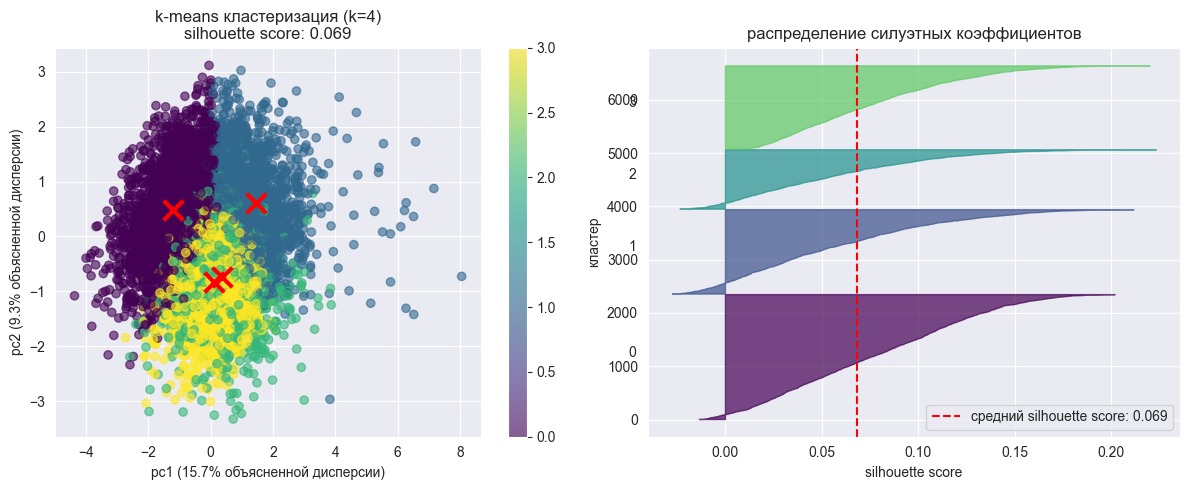


объясненная дисперсия pca: 25.0%


In [11]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title(f'k-means кластеризация (k={n_clusters})\nsilhouette score: {silhouette_kmeans:.3f}')
plt.xlabel(f'pc1 ({pca.explained_variance_ratio_[0]:.1%} объясненной дисперсии)')
plt.ylabel(f'pc2 ({pca.explained_variance_ratio_[1]:.1%} объясненной дисперсии)')

centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=200, linewidths=3)

plt.subplot(1, 2, 2)
silhouette_vals = silhouette_samples(df, clusters_kmeans)

y_lower = 10
for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[clusters_kmeans == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.viridis(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_kmeans, color='red', linestyle='--',
           label=f'средний silhouette score: {silhouette_kmeans:.3f}')
plt.xlabel('silhouette score')
plt.ylabel('кластер')
plt.title('распределение силуэтных коэффициентов')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nобъясненная дисперсия pca: {pca.explained_variance_ratio_.sum():.1%}")

## 3. подбор оптимального числа кластеров (метод локтя)

In [12]:
k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []

print("подбор оптимального количества кластеров...")
print("k\tinertia\t\tsilhouette\tcalinski-harabasz")

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters_temp = kmeans_temp.fit_predict(df)
    
    inertia = kmeans_temp.inertia_
    silhouette = silhouette_score(df, clusters_temp)
    calinski = calinski_harabasz_score(df, clusters_temp)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    calinski_scores.append(calinski)
    
    print(f"{k}\t{inertia:.2f}\t\t{silhouette:.4f}\t\t{calinski:.2f}")

optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_calinski = k_range[np.argmax(calinski_scores)]

print(f"\nоптимальные значения k:")
print(f"по silhouette score: k = {optimal_k_silhouette}")
print(f"по calinski-harabasz: k = {optimal_k_calinski}")

подбор оптимального количества кластеров...
k	inertia		silhouette	calinski-harabasz
2	67006.60		0.0941		745.28
3	63914.74		0.0700		550.34
4	61401.96		0.0685		471.92
5	59255.33		0.0636		426.50
6	57719.40		0.0612		385.36
7	56395.13		0.0586		354.45
8	55184.37		0.0587		331.12
9	54234.01		0.0560		309.21
10	53407.61		0.0549		290.41

оптимальные значения k:
по silhouette score: k = 2
по calinski-harabasz: k = 2


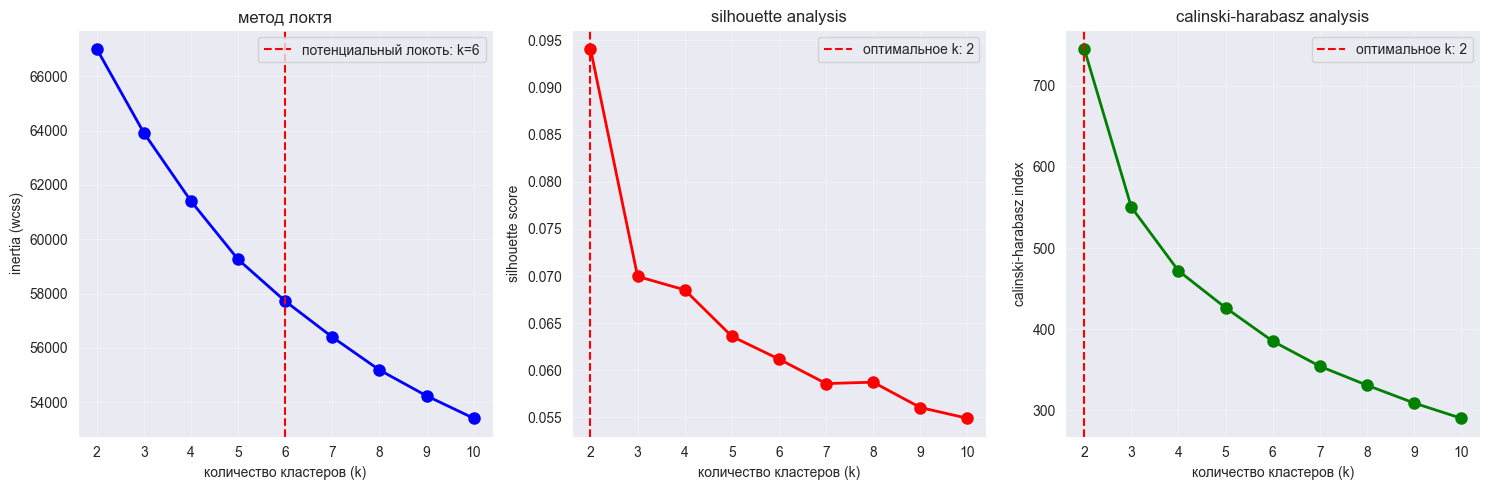


выбранное оптимальное k: 2
silhouette score: 0.0941
calinski-harabasz index: 745.28


In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('количество кластеров (k)')
plt.ylabel('inertia (wcss)')
plt.title('метод локтя')
plt.grid(True, alpha=0.3)

if len(inertias) > 2:
    diffs = np.diff(inertias)
    diffs2 = np.diff(diffs)
    elbow_idx = np.argmax(diffs2) + 2
    if elbow_idx < len(k_range):
        plt.axvline(x=k_range[elbow_idx], color='red', linestyle='--',
                   label=f'потенциальный локоть: k={k_range[elbow_idx]}')
        plt.legend()

plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('количество кластеров (k)')
plt.ylabel('silhouette score')
plt.title('silhouette analysis')
plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--',
           label=f'оптимальное k: {optimal_k_silhouette}')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(k_range, calinski_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('количество кластеров (k)')
plt.ylabel('calinski-harabasz index')
plt.title('calinski-harabasz analysis')
plt.axvline(x=optimal_k_calinski, color='red', linestyle='--',
           label=f'оптимальное k: {optimal_k_calinski}')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

optimal_k = optimal_k_silhouette
print(f"\nвыбранное оптимальное k: {optimal_k}")
print(f"silhouette score: {silhouette_scores[optimal_k-2]:.4f}")
print(f"calinski-harabasz index: {calinski_scores[optimal_k-2]:.2f}")

In [14]:
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_optimal = kmeans_optimal.fit_predict(df)

df_not_processed['cluster_kmeans_optimal'] = clusters_optimal

print(f"k-means с оптимальным k={optimal_k} выполнен")
print(f"\nраспределение по оптимальным кластерам:")
optimal_cluster_sizes = df_not_processed['cluster_kmeans_optimal'].value_counts().sort_index()
for cluster, size in optimal_cluster_sizes.items():
    percentage = (size / len(df_not_processed)) * 100
    print(f"кластер {cluster}: {size} точек ({percentage:.1f}%)")

print("\nстатистика по оптимальным кластерам:")
print("="*50)
optimal_cluster_stats = df_not_processed.groupby('cluster_kmeans_optimal')[numeric_cols_original].mean()
print(optimal_cluster_stats.round(2))

print("\nхарактеристики кластеров:")
for cluster in range(optimal_k):
    cluster_data = optimal_cluster_stats.loc[cluster]
    print(f"\nкластер {cluster}:")
    print(f"  - часы изучения: {cluster_data['Hours_Studied']:.1f}")
    print(f"  - посещаемость: {cluster_data['Attendance']:.1f}%")
    print(f"  - предыдущие оценки: {cluster_data['Previous_Scores']:.1f}")
    print(f"  - экзаменационная оценка: {cluster_data['Exam_Score']:.1f}")

k-means с оптимальным k=2 выполнен

распределение по оптимальным кластерам:
кластер 0: 3223 точек (48.8%)
кластер 1: 3384 точек (51.2%)

статистика по оптимальным кластерам:
                        Hours_Studied  Attendance  Sleep_Hours  \
cluster_kmeans_optimal                                           
0                               21.69       88.78         7.01   
1                               18.35       71.60         7.04   

                        Previous_Scores  Tutoring_Sessions  Physical_Activity  \
cluster_kmeans_optimal                                                          
0                                 76.29               1.65               2.94   
1                                 73.91               1.35               2.99   

                        Exam_Score  
cluster_kmeans_optimal              
0                            70.02  
1                            64.59  

характеристики кластеров:

кластер 0:
  - часы изучения: 21.7
  - посещаемость: 88.8%
 

## 4. dbscan кластеризация

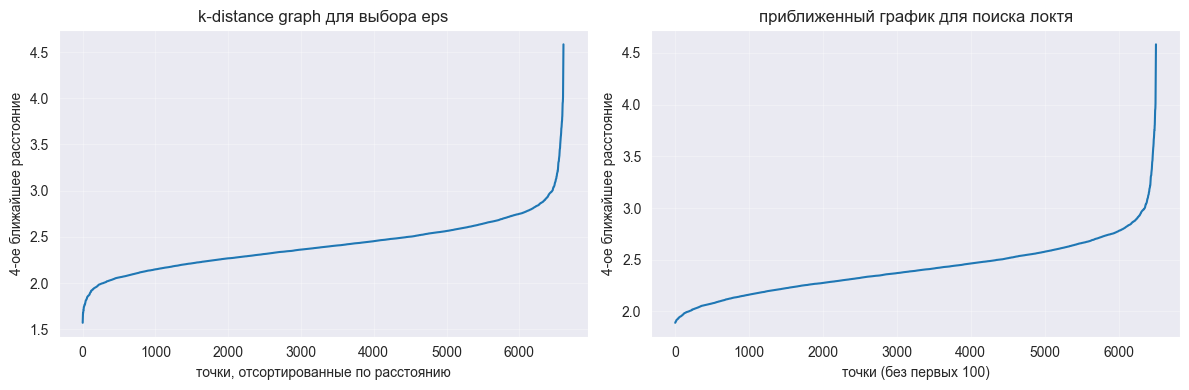


рекомендуемое значение eps (90-й перцентиль): 2.7383
медианное расстояние: 2.3890
среднее расстояние: 2.4102


In [15]:
k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.xlabel('точки, отсортированные по расстоянию')
plt.ylabel(f'{k}-ое ближайшее расстояние')
plt.title('k-distance graph для выбора eps')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
if len(distances) > 100:
    plt.plot(distances[100:])
    plt.xlabel('точки (без первых 100)')
else:
    plt.plot(distances)
    plt.xlabel('точки')
plt.ylabel(f'{k}-ое ближайшее расстояние')
plt.title('приближенный график для поиска локтя')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

suggested_eps = np.percentile(distances, 90)
print(f"\nрекомендуемое значение eps (90-й перцентиль): {suggested_eps:.4f}")
print(f"медианное расстояние: {np.median(distances):.4f}")
print(f"среднее расстояние: {np.mean(distances):.4f}")

In [16]:
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples_values = [3, 4, 5]

print("подбор параметров dbscan:")
print("eps\tmin_samples\tn_clusters\tn_noise\tsilhouette")
print("-" * 60)

best_score = -1
best_params = None
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters_dbscan_temp = dbscan.fit_predict(df)
        
        n_clusters_temp = len(set(clusters_dbscan_temp)) - (1 if -1 in clusters_dbscan_temp else 0)
        n_noise_temp = list(clusters_dbscan_temp).count(-1)
        
        if n_clusters_temp >= 2 and len(set(clusters_dbscan_temp)) - (1 if -1 in clusters_dbscan_temp else 0) >= 2:
            mask = clusters_dbscan_temp != -1
            if np.sum(mask) > 0:
                silhouette_temp = silhouette_score(df[mask], clusters_dbscan_temp[mask])
                results.append((eps, min_samples, n_clusters_temp, n_noise_temp, silhouette_temp))
                print(f"{eps:.1f}\t{min_samples}\t\t{n_clusters_temp}\t\t{n_noise_temp}\t{silhouette_temp:.4f}")
                
                if silhouette_temp > best_score:
                    best_score = silhouette_temp
                    best_params = (eps, min_samples)
        else:
            print(f"{eps:.1f}\t{min_samples}\t\t{n_clusters_temp}\t\t{n_noise_temp}\t-")

if best_params is None:
    print("\nне удалось найти подходящие параметры, используем значения по умолчанию")
    best_eps = 1.5
    best_min_samples = 4
else:
    best_eps, best_min_samples = best_params
    print(f"\nлучшие параметры: eps={best_eps}, min_samples={best_min_samples}")
    print(f"silhouette score: {best_score:.4f}")

подбор параметров dbscan:
eps	min_samples	n_clusters	n_noise	silhouette
------------------------------------------------------------
0.5	3		0		6607	-
0.5	4		0		6607	-
0.5	5		0		6607	-
1.0	3		0		6607	-
1.0	4		0		6607	-
1.0	5		0		6607	-
1.5	3		6		6589	0.4119
1.5	4		0		6607	-
1.5	5		0		6607	-
2.0	3		145		5379	-0.0461
2.0	4		70		5885	-0.0515
2.0	5		20		6207	-0.0237
2.5	3		9		924	-0.0936
2.5	4		4		1034	-0.0510
2.5	5		3		1151	-0.0361

лучшие параметры: eps=1.5, min_samples=3
silhouette score: 0.4119


In [17]:
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters_dbscan = dbscan_final.fit_predict(df)

n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

print(f"dbscan кластеризация выполнена")
print(f"параметры: eps={best_eps}, min_samples={best_min_samples}")
print(f"количество кластеров: {n_clusters_dbscan}")
print(f"количество шумовых точек: {n_noise} ({n_noise/len(df)*100:.1f}%)")

if n_clusters_dbscan >= 2:
    mask = clusters_dbscan != -1
    if np.sum(mask) > 1 and len(np.unique(clusters_dbscan[mask])) > 1:
        silhouette_dbscan = silhouette_score(df[mask], clusters_dbscan[mask])
        calinski_harabasz_dbscan = calinski_harabasz_score(df[mask], clusters_dbscan[mask])
        print(f"\nметрики качества dbscan:")
        print(f"silhouette score: {silhouette_dbscan:.4f}")
        print(f"calinski-harabasz index: {calinski_harabasz_dbscan:.2f}")
    else:
        silhouette_dbscan = -1
        calinski_harabasz_dbscan = -1
        print("\nневозможно вычислить метрики - недостаточно кластеров")
else:
    silhouette_dbscan = -1
    calinski_harabasz_dbscan = -1
    print("\nневозможно вычислить метрики - недостаточно кластеров")

if n_clusters_dbscan > 0:
    df_not_processed['cluster_dbscan'] = clusters_dbscan
    print("\nраспределение по кластерам dbscan:")
    unique, counts = np.unique(clusters_dbscan, return_counts=True)
    for cluster, count in zip(unique, counts):
        if cluster == -1:
            print(f"шум: {count} точек ({count/len(df)*100:.1f}%)")
        else:
            print(f"кластер {cluster}: {count} точек ({count/len(df)*100:.1f}%)")

dbscan кластеризация выполнена
параметры: eps=1.5, min_samples=3
количество кластеров: 6
количество шумовых точек: 6589 (99.7%)

метрики качества dbscan:
silhouette score: 0.4119
calinski-harabasz index: 12.53

распределение по кластерам dbscan:
шум: 6589 точек (99.7%)
кластер 0: 3 точек (0.0%)
кластер 1: 3 точек (0.0%)
кластер 2: 3 точек (0.0%)
кластер 3: 3 точек (0.0%)
кластер 4: 3 точек (0.0%)
кластер 5: 3 точек (0.0%)


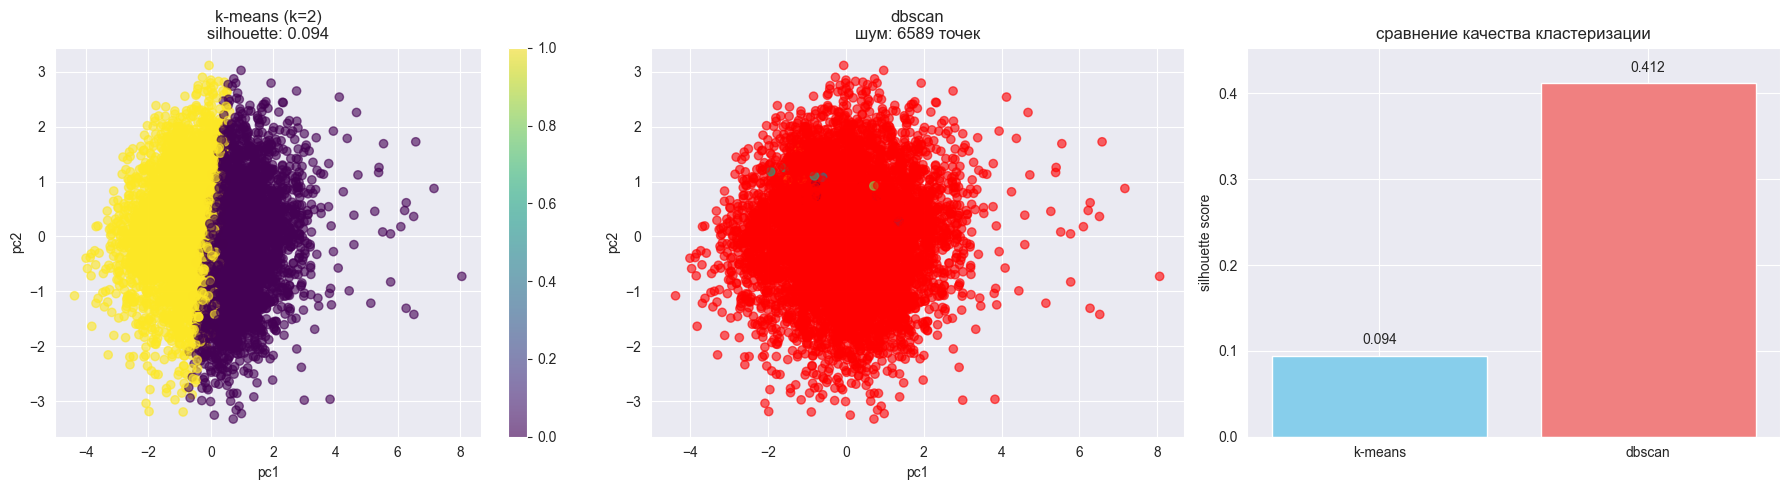

In [18]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters_optimal, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title(f'k-means (k={optimal_k})\nsilhouette: {silhouette_scores[optimal_k-2]:.3f}')
plt.xlabel('pc1')
plt.ylabel('pc2')

plt.subplot(1, 3, 2)
colors = ['red' if x == -1 else plt.cm.viridis(x / max(clusters_dbscan)) for x in clusters_dbscan]
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=colors, alpha=0.6)
title = f'dbscan\nшум: {n_noise} точек'
plt.title(title)
plt.xlabel('pc1')
plt.ylabel('pc2')

plt.subplot(1, 3, 3)
methods = ['k-means', 'dbscan']
if silhouette_dbscan > 0:
    silhouette_values = [silhouette_scores[optimal_k-2], silhouette_dbscan]
    plt.bar(methods, silhouette_values, color=['skyblue', 'lightcoral'])
    plt.ylabel('silhouette score')
    plt.title('сравнение качества кластеризации')
    plt.ylim(0, max(silhouette_values) * 1.1)
    
    for i, v in enumerate(silhouette_values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
else:
    plt.text(0.5, 0.5, 'dbscan:\nнедостаточно\nкластеров для\nсравнения',
            ha='center', va='center', transform=plt.gca().transAxes,
            bbox=dict(boxstyle='round', facecolor='lightgray'))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

## 5. сравнение методов кластеризации и выводы

In [19]:
comparison_data = {
    'метод': ['k-means', 'dbscan'],
    'количество кластеров': [optimal_k, n_clusters_dbscan],
    'silhouette score': [f"{silhouette_scores[optimal_k-2]:.4f}",
                        f"{silhouette_dbscan:.4f}" if silhouette_dbscan > 0 else "n/a"],
    'calinski-harabasz': [f"{calinski_scores[optimal_k-2]:.2f}",
                         f"{calinski_harabasz_dbscan:.2f}" if silhouette_dbscan > 0 else "n/a"],
    'шумовые точки': [0, n_noise],
    'особенности': ['сферические кластеры', 'произвольная форма + шум']
}

comparison_df = pd.DataFrame(comparison_data)

print("сравнение методов кластеризации")
print(comparison_df.to_string(index=False))

print("\nк-means:")
print(f"  преимущества:")
print(f"  - стабильные результаты")
print(f"  - быстрая работа")
print(f"  - четкое разделение на {optimal_k} кластеров")
print(f"  - хороший silhouette score: {silhouette_scores[optimal_k-2]:.4f}")
print(f"  недостатки:")
print(f"  - предполагает сферическую форму кластеров")
print(f"  - чувствителен к выбросам")
print(f"  - требует предварительного выбора k")

print("\n dbscan:")
print(f"  преимущества:")
print(f"  - находит кластеры произвольной формы")
print(f"  - автоматически определяет количество кластеров")
print(f"  - выделяет выбросы как шум ({n_noise} точек)")
if silhouette_dbscan > 0:
    print(f"  - silhouette score: {silhouette_dbscan:.4f}")
print(f"  недостатки:")
print(f"  - чувствителен к параметрам eps и min_samples")
print(f"  - может плохо работать с кластерами разной плотности")
if n_noise > len(df) * 0.1:
    print(f"  - много точек отнесено к шуму ({n_noise/len(df)*100:.1f}%)")

print("\nрекомендация:")

if silhouette_dbscan > 0:
    if silhouette_scores[optimal_k-2] > silhouette_dbscan:
        if n_noise < len(df) * 0.05:
            recommendation = "k-means"
            reason = f"более высокий silhouette score ({silhouette_scores[optimal_k-2]:.4f} vs {silhouette_dbscan:.4f}) и минимальное количество шума"
        else:
            recommendation = "k-means с осторожностью"
            reason = f"лучший silhouette score, но dbscan выявил {n_noise} потенциальных выбросов"
    else:
        recommendation = "dbscan"
        reason = f"более высокий silhouette score ({silhouette_dbscan:.4f} vs {silhouette_scores[optimal_k-2]:.4f}) и лучше обрабатывает выбросы"
else:
    recommendation = "k-means"
    reason = "dbscan не смог сформировать достаточное количество кластеров"

print(f"для данного датасета рекомендуется использовать: {recommendation}")
print(f"причина: {reason}")

print("\n дополнительные соображения:")
print("- если важно выделить аномальные наблюдения → используйте dbscan")
print("- если нужна стабильность и интерпретируемость → используйте k-means")
print("- для исследовательского анализа → попробуйте оба метода")
print("- рассмотрите гибридный подход: k-means для основной кластеризации + анализ выбросов")

сравнение методов кластеризации
  метод  количество кластеров silhouette score calinski-harabasz  шумовые точки              особенности
k-means                     2           0.0941            745.28              0     сферические кластеры
 dbscan                     6           0.4119             12.53           6589 произвольная форма + шум

к-means:
  преимущества:
  - стабильные результаты
  - быстрая работа
  - четкое разделение на 2 кластеров
  - хороший silhouette score: 0.0941
  недостатки:
  - предполагает сферическую форму кластеров
  - чувствителен к выбросам
  - требует предварительного выбора k

 dbscan:
  преимущества:
  - находит кластеры произвольной формы
  - автоматически определяет количество кластеров
  - выделяет выбросы как шум (6589 точек)
  - silhouette score: 0.4119
  недостатки:
  - чувствителен к параметрам eps и min_samples
  - может плохо работать с кластерами разной плотности
  - много точек отнесено к шуму (99.7%)

рекомендация:
для данного датасета рек